In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, fbeta_score, classification_report, ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, det_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline

In [2]:
full_data = pd.read_csv("../data/processed/full_all_day_ahead.csv")
full_data.head()

cols_1_day_ahead = [c for c in full_data.columns if c == "Abnormal" or c.endswith("_1")]
data_1da = full_data[cols_1_day_ahead]

# data_1da[data_1da.isna().any(axis=1)]

data_1da = data_1da.dropna()
X_1da = data_1da.drop(columns="Abnormal")
y_1da = data_1da["Abnormal"]

## RR_1 appears to always have same value
X_1da["RR_1"].unique()
X_1da = X_1da.drop(columns="RR_1")

y_bin = LabelEncoder().fit_transform(y_1da)

# Test-train split
np.random.seed(7406)
X_train, X_test, y_train, y_test = train_test_split(X_1da, y_bin, train_size=0.7, stratify=y_bin)

## Feature clustering

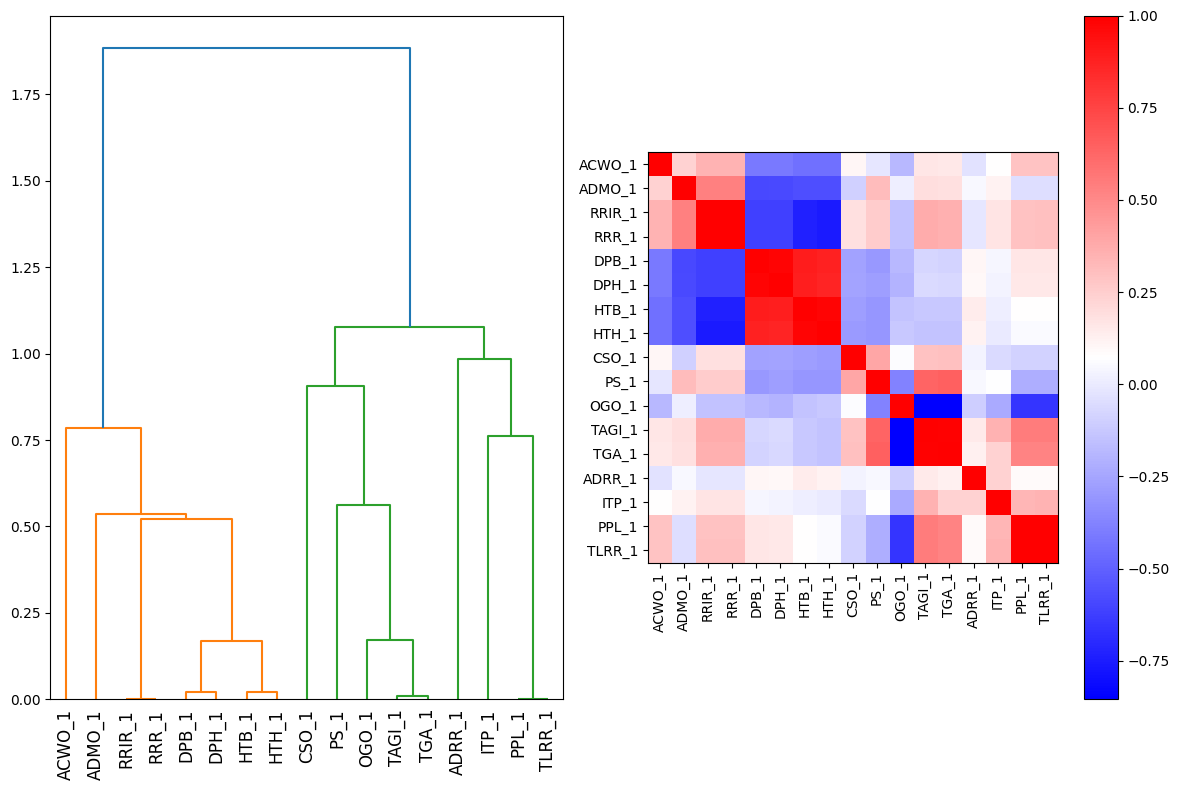

In [3]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap="bwr")
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.colorbar(im)
_ = fig.tight_layout()

## SMOTE and PCA

In [4]:
smote = SMOTE(n_jobs=-1, k_neighbors=10)
X_rs, y_rs = smote.fit_resample(X_train, y_train)

c:\Users\willc\OneDrive\OMSA\03 SP24 ISYE7406 DMSL\Project\dmsl-project\env\Lib\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [5]:
pca = PCA()
pca.fit(StandardScaler().fit_transform(X_rs))
pca.explained_variance_ratio_.cumsum()

array([0.36366318, 0.61471538, 0.73615156, 0.80226507, 0.86171149,
       0.91271891, 0.94930088, 0.97549774, 0.99194757, 0.99862592,
       0.9993682 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

## Model Building

In [6]:
kf = StratifiedKFold(n_splits=10, shuffle=True)
scaler = StandardScaler()

pipeline = Pipeline([("scaler", scaler),
                     ("lr", LogisticRegression(n_jobs=-1))])

param_grid = {
  "lr__C": [0.0001, 0.01, 0.1, 1, 10, 100, 1000],
  "lr__fit_intercept": [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(fbeta_score, beta=2), cv=kf, refit=True)
grid_search.fit(X_rs, y_rs)
print(grid_search.best_params_)
print(grid_search.best_estimator_.named_steps["lr"].coef_)

{'lr__C': 0.1, 'lr__fit_intercept': False}
[[ 0.15476336 -0.145302    0.01975054 -0.36542971  0.28384422  0.29094161
  -1.02902388 -1.3165916   0.17913077 -0.00861755  0.60941839 -0.6988125
  -0.84357    -0.84357    -0.14021957 -0.17343109  0.60684493]]


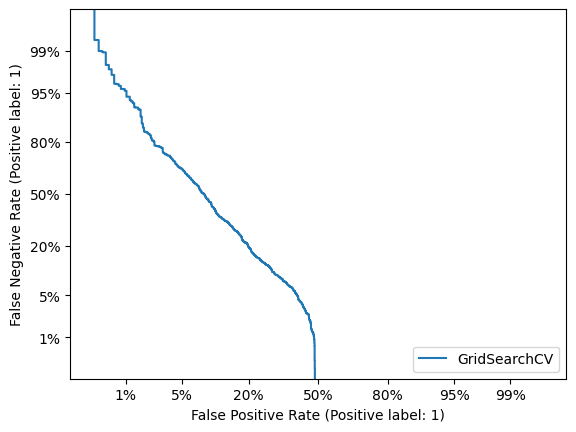

In [7]:
DetCurveDisplay.from_estimator(grid_search, X_rs, y_rs)

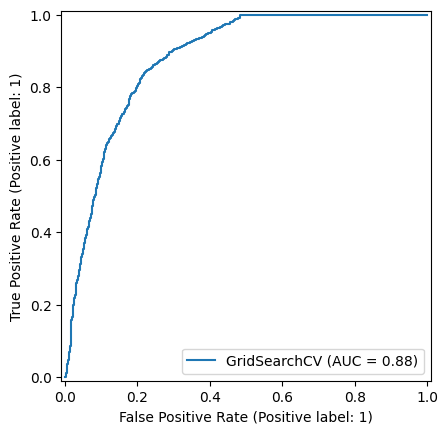

In [8]:
RocCurveDisplay.from_estimator(grid_search, X_rs, y_rs)

In [9]:
y_train_proba = grid_search.predict_proba(X_rs)[:,1]
fpr1, fnr, det_ts = det_curve(y_rs, y_train_proba)
fpr2, tpr, roc_ts = roc_curve(y_rs, y_train_proba)

sens = 1-fnr
spec = 1-fpr1


print("DET optimal threshold = ",det_ts[np.argmax(sens+spec)])
print("ROC optimal threshold =", roc_ts[np.argmax(tpr-fpr2)])


DET optimal threshold =  0.5275070697117371
ROC optimal threshold = 0.5279719562915989


## Metrics

0.7714544836186373
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1764
           1       0.77      0.77      0.77      1764

    accuracy                           0.77      3528
   macro avg       0.77      0.77      0.77      3528
weighted avg       0.77      0.77      0.77      3528



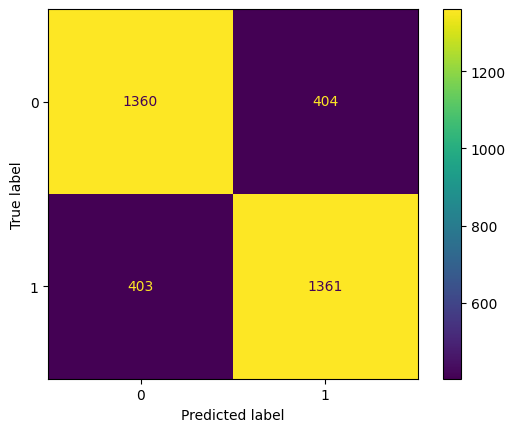

In [17]:
y_train_pred = [0 if p < 0.528 else 1 for p in y_train_proba]
y_test_pred = [0 if p < 0.528 else 1 for p in grid_search.predict_proba(X_test)[:,1]]

print(fbeta_score(y_rs, y_train_pred, beta=2))
print(classification_report(y_rs, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_rs, y_train_pred)

0.17094017094017094
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       756
           1       0.04      0.73      0.08        11

    accuracy                           0.76       767
   macro avg       0.52      0.74      0.47       767
weighted avg       0.98      0.76      0.85       767



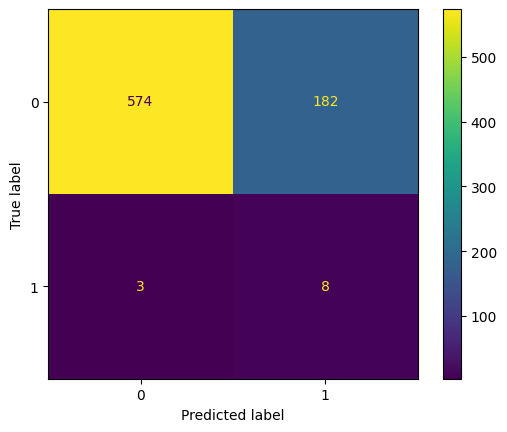

In [18]:
print(fbeta_score(y_test, y_test_pred, beta=2))
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [13]:
pca_pipeline = pipeline = Pipeline([("scaler", scaler),
                                    ("pca", PCA(n_components=6)),
                                    ("lr", LogisticRegression(n_jobs=-1))])

pca_grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(fbeta_score, beta=2), cv=kf, refit=True)
pca_grid_search.fit(X_rs, y_rs)
print(pca_grid_search.best_params_)
print(pca_grid_search.best_estimator_.named_steps["lr"].coef_)

{'lr__C': 1, 'lr__fit_intercept': False}
[[-0.20392915 -0.07456103  1.03218552  0.37309262 -0.43564079  0.89285615]]


In [14]:
y_train_proba = pca_grid_search.predict_proba(X_rs)[:,1]
fpr1, fnr, det_ts = det_curve(y_rs, y_train_proba)
fpr2, tpr, roc_ts = roc_curve(y_rs, y_train_proba)

sens = 1-fnr
spec = 1-fpr1


print("DET optimal threshold = ",det_ts[np.argmax(sens+spec)])
print("ROC optimal threshold =", roc_ts[np.argmax(tpr-fpr2)])

DET optimal threshold =  0.47428002478409287
ROC optimal threshold = 0.47428002478409287


0.8080864335041212
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1764
           1       0.75      0.82      0.79      1764

    accuracy                           0.78      3528
   macro avg       0.78      0.78      0.78      3528
weighted avg       0.78      0.78      0.78      3528



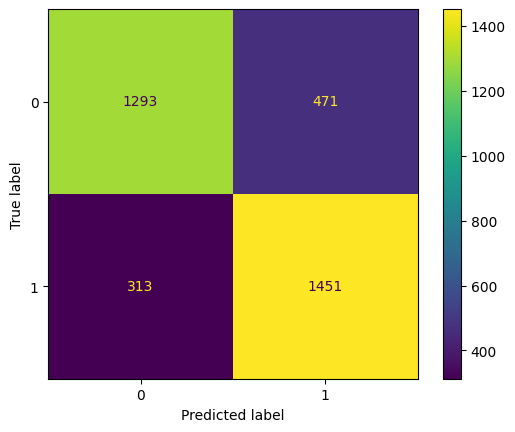

In [15]:
y_train_pred = [0 if p < 0.47428 else 1 for p in y_train_proba]
y_test_pred = [0 if p < 0.47428 else 1 for p in pca_grid_search.predict_proba(X_test)[:,1]]

print(fbeta_score(y_rs, y_train_pred, beta=2))
print(classification_report(y_rs, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_rs, y_train_pred)

0.17374517374517376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84       756
           1       0.04      0.82      0.08        11

    accuracy                           0.73       767
   macro avg       0.52      0.77      0.46       767
weighted avg       0.98      0.73      0.83       767



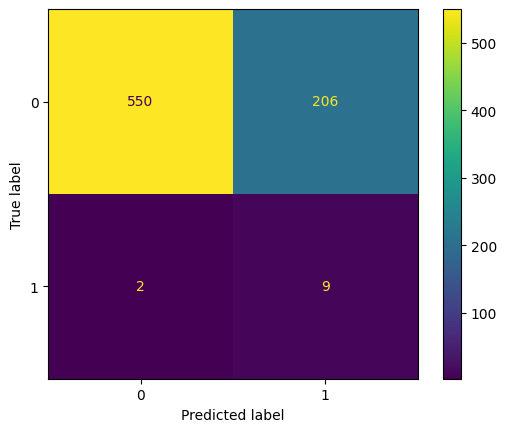

In [16]:
print(fbeta_score(y_test, y_test_pred, beta=2))
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)